In [362]:
# Sources : 

# Effective Federal Funds Rate (EFFR)
# https://www.newyorkfed.org/markets/reference-rates/effr

# Target Range of the Federal Funds Rate (FFTR)
# https://www.federalreserve.gov/economy-at-a-glance-policy-rate.htm

# TBOND
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025

# ARIMA model
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
pip install --upgrade git+https://github.com/Matteo-Bernard/EcoWatch.git

  Cloning https://github.com/Matteo-Bernard/EcoWatch.git to /private/var/folders/2b/32s1c6ld3y50klj4yfqh9qmc0000gn/T/pip-req-build-m74d69oq
  Running command git clone --filter=blob:none --quiet https://github.com/Matteo-Bernard/EcoWatch.git /private/var/folders/2b/32s1c6ld3y50klj4yfqh9qmc0000gn/T/pip-req-build-m74d69oq
  Resolved https://github.com/Matteo-Bernard/EcoWatch.git to commit 4696ae2378305d7d7d9b6afb346eee2371000b8f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


### Scraping endogène and inendogène datas

In [2]:
from EcoWatch.Scraping import tbond
import numpy as np

# Get the US Treasury Bonds dataset
tbond = tbond('2008', '2024')
tbond = tbond.drop(['20 Yr', '30 Yr'], axis=1) # Drop unrelevant maturities
tbond = tbond.interpolate(axis=1) # Interpolate missing values
tbond = tbond.resample('W').last()
tbond = tbond.dropna(axis=0)

# Define the maturities of the US Treasury Bonds
maturities = np.unique([
    int(col.split()[0]) / 12 if "Mo" in col else int(col.split()[0])
    for col in tbond.columns
])


### Feature Engineering

In [19]:
from EcoWatch.NelsonSiegelCurvature import NSC

# Define parameter bounds for optimization: 
bounds = [(0, 1), (-1, 1), (-1, 1), (0, 5)] # Intercept (β0), Slope (β1), Curvature (β2), and Time delta (λ1)
x0 = [0.01, 0.01, 0.01, 0.5] # Initial guess for the optimization algorithm
method = 'SLSQP' # Optimization method used for minimization

# Create an instance of the Nelson-Siegel-Curvature class
NelsonSiegelCurvature = NSC(maturities=maturities, bounds=bounds, x0=x0, method=method)

# Adjust Nelson-Siegel parameters for the curve
nsc = NelsonSiegelCurvature.fit(yields=tbond)
nsc = nsc.resample('W').last()

Fitting Nelson-Siegel: 888it [00:05, 170.26it/s]


In [20]:
# Display the US Treasury Bonds dataset description
print("US Treasury bonds description")
print("==============================================================================")
print(tbond.describe().round(2).to_string()) 
print("\n")

# Display the Nelson-Siegel-Curvature dataset description
print("Neslon Siegel Parameters description")
print("==============================================================================")
print(nsc.describe().round(6).to_string()) 

US Treasury bonds description
         1 Mo    2 Mo    3 Mo    4 Mo    6 Mo    1 Yr    2 Yr    3 Yr    5 Yr    7 Yr   10 Yr
count  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00  888.00
mean     1.13    1.17    1.19    1.24    1.27    1.34    1.48    1.65    2.01    2.33    2.61
std      1.71    1.72    1.72    1.72    1.69    1.61    1.42    1.28    1.09    1.00    0.94
min      0.00    0.00    0.00    0.02    0.02    0.04    0.09    0.11    0.21    0.39    0.55
25%      0.04    0.05    0.06    0.08    0.11    0.17    0.38    0.71    1.24    1.55    1.91
50%      0.14    0.16    0.18    0.24    0.32    0.49    0.88    1.27    1.75    2.18    2.54
75%      1.70    1.74    1.81    1.90    1.96    2.07    2.28    2.40    2.65    2.99    3.39
max      6.02    5.60    5.63    5.64    5.61    5.46    5.10    4.93    4.86    4.93    4.93


Neslon Siegel Parameters description
               b1          b2          b3          l1           r
count  888.000000  

### Analyse des ordres des séries

In [21]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf

def correlogram(data, nlags=15, title='Correlogram'):
    c = pd.concat([
        pd.DataFrame(acf(data.dropna(), nlags=nlags+1, qstat=True), index=['ACF', 'Q-stat', 'Prob']).T,
        pd.DataFrame(pacf(data.dropna(), nlags=nlags+1), columns=['PACF']),
    ],axis=1).dropna().round(3)
    print(title)
    print('==============================================================================')
    print(c[['ACF', 'PACF', 'Q-stat', 'Prob']])

In [22]:
data = nsc['b1']
correlogram(data, nlags=15, title=f'β1 - Intercept Correlogram')
print('\n')

print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")   
print('\n')

data = nsc['b2']
correlogram(data, nlags=15, title=f'β2 - Slope Correlogram')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")      
print('\n')

data = nsc['b3']
correlogram(data, nlags=15, title=f'β3 - Intercept Correlogram')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")        
print('\n')

data = nsc['l1']
correlogram(data, nlags=15, title=f'λ1 - Time decay Correlogram')
print('ADF Test : ')
print('==============================================================================')
result = adfuller(data)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")             

β1 - Intercept Correlogram
      ACF   PACF     Q-stat  Prob
0   1.000  1.000    864.636   0.0
1   0.985  0.986   1707.248   0.0
2   0.972  0.055   2527.374   0.0
3   0.958 -0.019   3325.335   0.0
4   0.945 -0.008   4101.071   0.0
5   0.931 -0.015   4856.589   0.0
6   0.918  0.030   5589.999   0.0
7   0.904 -0.051   6302.408   0.0
8   0.891  0.004   6993.897   0.0
9   0.877 -0.010   7664.005   0.0
10  0.863 -0.027   8316.306   0.0
11  0.851  0.071   8951.496   0.0
12  0.839  0.011   9569.526   0.0
13  0.827 -0.011  10170.482   0.0
14  0.815 -0.013  10755.381   0.0
15  0.804  0.011  11323.594   0.0


ADF Test : 
ADF Statistic: -1.6596
p-value: 0.452
Critical Values:
   1% : -3.4378
   5% : -2.8648
   10% : -2.5685


β2 - Slope Correlogram
      ACF   PACF     Q-stat  Prob
0   1.000  1.000    871.423   0.0
1   0.989  0.990   1724.056   0.0
2   0.978 -0.017   2559.355   0.0
3   0.967  0.031   3379.659   0.0
4   0.958  0.058   4184.961   0.0
5   0.949 -0.009   4975.322   0.0
6   0.939 -0.0

In [124]:
from statsmodels.tsa.arima.model import ARIMA
nsc_train = nsc.iloc[:int(len(nsc)*0.80)].drop('r', axis=1)
nsc_test = nsc.iloc[-int(len(nsc)*0.20):].drop('r', axis=1)

# Intercept
print('β1 - Intercept Model Summary : ')
print('==============================================================================')
b1_arima = ARIMA(
    nsc_train['b1'], 
    order=(2, 1, 2),
).fit()
print(b1_arima.summary())
print('\n')

# Slope
print('β2 - Slope Model Summary : ')
print('==============================================================================')
b2_arima = ARIMA(
    nsc_train['b2'], 
    order=(4, 1, 2),
).fit()
print(b2_arima.summary())
print('\n')

# Curvature
print('β3 - Curvature Model Summary : ')
print('==============================================================================')
b3_arima = ARIMA(
    nsc_train['b3'], 
    order=(5, 1, 2),
).fit()
print(b3_arima.summary())
print('\n')

# Lambda
print('λ1 - time-decay Model Summary : ')
print('==============================================================================')
l1_arima = ARIMA(
    nsc_train['l1'], 
    order=(1, 1, 2),
).fit()
print(l1_arima.summary())

β1 - Intercept Model Summary : 
                               SARIMAX Results                                
Dep. Variable:                     b1   No. Observations:                  710
Model:                 ARIMA(2, 1, 2)   Log Likelihood                3680.821
Date:                Sun, 20 Apr 2025   AIC                          -7351.641
Time:                        16:12:56   BIC                          -7328.822
Sample:                    01-06-2008   HQIC                         -7342.825
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0352      0.685      0.051      0.959      -1.308       1.378
ar.L2         -0.1166      0.366     -0.319      0.750      -0.834       0.601
ma.L1         -0.142

In [125]:
correlogram(b1_arima.resid, title='β1 - Intercept Correlogram of Residuals')
correlogram(b1_arima.resid**2, title='β1 - Intercept Correlogram of Squared Residuals')
print('\n')
correlogram(b2_arima.resid, title='β2 - Slope Correlogram of Residuals')
correlogram(b2_arima.resid**2, title='β2 - Slope Correlogram of Squared Residuals')
print('\n')
correlogram(b3_arima.resid, title='β3 - Curvature Correlogram of Residuals')
correlogram(b3_arima.resid**2, title='β3 - Curvature Correlogram of Squared Residuals')
print('\n')
correlogram(l1_arima.resid, title='λ1 - Time-decay Correlogram of Residuals')
correlogram(l1_arima.resid**2, title='λ1 - Time-decay Correlogram of Squared Residuals')

β1 - Intercept Correlogram of Residuals
      ACF   PACF  Q-stat   Prob
0   1.000  1.000   0.033  0.855
1  -0.007 -0.007   0.884  0.643
2  -0.035 -0.035   0.901  0.825
3   0.005  0.004   1.268  0.867
4   0.023  0.022   1.368  0.928
5  -0.012 -0.011   1.511  0.959
6   0.014  0.016   1.521  0.982
7  -0.004 -0.005   1.529  0.992
8   0.003  0.004   1.855  0.994
9   0.021  0.022   3.469  0.968
10 -0.047 -0.048   3.868  0.974
11 -0.023 -0.023   4.824  0.964
12  0.036  0.033   5.399  0.965
13  0.028  0.027   5.543  0.977
14  0.014  0.020   7.372  0.947
15  0.050  0.053   7.882  0.952
β1 - Intercept Correlogram of Squared Residuals
      ACF   PACF  Q-stat   Prob
0   1.000  1.000   0.000  0.983
1  -0.001 -0.001   0.010  0.995
2   0.004  0.004   0.010  1.000
3  -0.001 -0.001   0.011  1.000
4  -0.001 -0.001   0.011  1.000
5  -0.001 -0.001   0.013  1.000
6   0.001  0.002   0.013  1.000
7  -0.001 -0.001   0.038  1.000
8   0.006  0.006   0.039  1.000
9  -0.001 -0.001   0.039  1.000
10 -0.000 -0.000

In [126]:
from tqdm import tqdm
import numpy as np

nsc_pred = nsc_test.copy()
nsc_pred[:] = np.nan
b1_arima_pred = b1_arima
b2_arima_pred = b2_arima
b3_arima_pred = b3_arima
l1_arima_pred = l1_arima

for t in tqdm(nsc_pred.index):
    
    b1_pred = b1_arima_pred.forecast(steps=1, dynamic=False)
    b2_pred = b2_arima_pred.forecast(steps=1, dynamic=False)
    b3_pred = b3_arima_pred.forecast(steps=1, dynamic=False)
    l1_pred = l1_arima_pred.forecast(steps=1, dynamic=False)

    b1_arima_pred = b1_arima_pred.append([pd.Series(nsc_test.loc[t, 'b1'], index=[t])], refit=False)
    b2_arima_pred = b2_arima_pred.append([pd.Series(nsc_test.loc[t, 'b2'], index=[t])], refit=False)
    b3_arima_pred = b3_arima_pred.append([pd.Series(nsc_test.loc[t, 'b3'], index=[t])], refit=False)
    l1_arima_pred = l1_arima_pred.append([pd.Series(nsc_test.loc[t, 'l1'], index=[t])], refit=False)

    nsc_pred.loc[t] = [
        b1_pred.values[0], 
        b2_pred.values[0], 
        b3_pred.values[0], 
        l1_pred.values[0]
    ]

  0%|          | 0/177 [00:00<?, ?it/s]

100%|██████████| 177/177 [03:49<00:00,  1.30s/it]


In [127]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def eval(test, pred, title='Eval'):
    print(title)
    print('==============================================================================')    
    mape = mean_absolute_percentage_error(test, pred)
    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = root_mean_squared_error(test, pred)
    r2 = r2_score(test, pred)

    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.4f}")
    print(f"R2 : {r2:.4f}")

In [128]:
eval(nsc_test['b1'], nsc_pred['b1'], title='Eval of β1 - Intercept')
print('\n')
eval(nsc_test['b2'], nsc_pred['b2'], title='Eval of β2 - Slope')
print('\n')
eval(nsc_test['b3'], nsc_pred['b3'], title='Eval of β3 - Curvature')
print('\n')
eval(nsc_test['l1'], nsc_pred['l1'], title='Eval of λ1 - Time-decay')

Eval of β1 - Intercept
MAE : 0.0014
MSE : 0.0000
RMSE : 0.0017
MAPE : 0.0431
R2 : 0.9630


Eval of β2 - Slope
MAE : 0.0018
MSE : 0.0000
RMSE : 0.0023
MAPE : 0.3020
R2 : 0.9775


Eval of β3 - Curvature
MAE : 0.0028
MSE : 0.0000
RMSE : 0.0047
MAPE : 0.2239
R2 : 0.9458


Eval of λ1 - Time-decay
MAE : 0.0001
MSE : 0.0000
RMSE : 0.0002
MAPE : 0.0003
R2 : 0.7909


In [129]:
def nsc_to_curve(P, T):
    """Calcule la courbe Nelson-Siegel pour un jeu de paramètres P et des maturités T."""
    return (P[0] +
            P[1] * ((1 - np.exp(-T / P[3])) / (T / P[3])) +
            P[2] * (((1 - np.exp(-T / P[3])) / (T / P[3])) - np.exp(-T / P[3])))

tbond_pred = pd.DataFrame(columns=tbond.columns, index=nsc_pred.index)
for t in nsc_pred.index:
    tbond_pred.loc[t] = nsc_to_curve(P=nsc_pred.loc[t].values, T=maturities)
tbond_test = tbond.loc[tbond_pred.index[0]:]/100

In [130]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def mean_percentage_error(test, pred):
    test, pred = np.array(test), np.array(pred)
    return np.mean((test - pred) / test)

tbond_eval = pd.DataFrame(columns=tbond_pred.columns)
for n in tbond_pred.columns:
        test = tbond_test[n].dropna()
        pred = tbond_pred[n].dropna()

        tbond_eval.loc['RMSE', n]  = f"{root_mean_squared_error(test, pred):.2f}"
        tbond_eval.loc['MSE', n]  = f"{mean_squared_error(test, pred):.2f}"
        tbond_eval.loc['MAPE (%)', n] = f"{mean_absolute_percentage_error(test, pred):.2%}"
        tbond_eval.loc['MPE (%)', n] = f"{mean_percentage_error(test, pred):.2%}"
        tbond_eval.loc['MAE', n]  = f"{mean_absolute_error(test, pred):.2f}"
        tbond_eval.loc['R2', n]  = f"{r2_score(test, pred):.2f}"

tbond_eval

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr
RMSE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MSE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MAPE (%),38.52%,9.71%,10.00%,19.35%,23.17%,7.51%,7.75%,6.63%,4.22%,4.41%,4.98%
MPE (%),-28.01%,-3.67%,8.65%,18.91%,22.02%,5.05%,-4.12%,-2.57%,-0.39%,2.26%,2.84%
MAE,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
R2,0.99,1.00,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.98,0.97


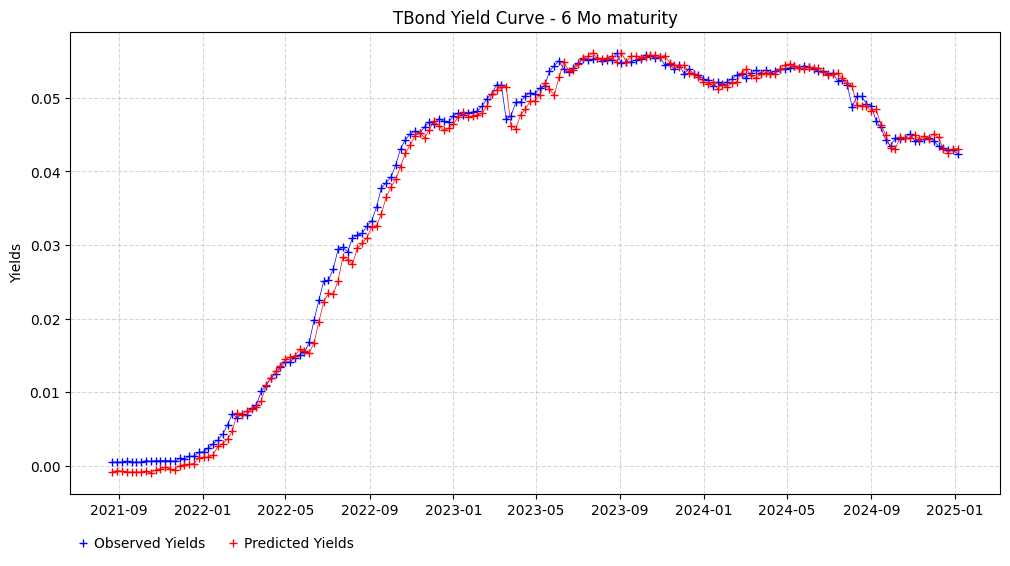

In [131]:
import matplotlib.pyplot as plt

t='6 Mo'
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot of observed bond yields
ax1.plot(tbond_pred.index, tbond_test[t], color='blue', linestyle='-', marker='+', linewidth=0.5, label="Observed Yields")
ax1.plot(tbond_pred.index, tbond_pred[t], color='red', linestyle='-', marker='+', linewidth=0.5, label="Predicted Yields")
ax1.set_ylabel('Yields', color='black')

ax1.legend(bbox_to_anchor=(0, -0.15), loc='lower left', ncol=2, frameon=False, handlelength=0)


# Set plot title with the last available date in the dataset
plt.title(f"TBond Yield Curve - {t} maturity")
plt.grid(alpha=0.5, linestyle='--')

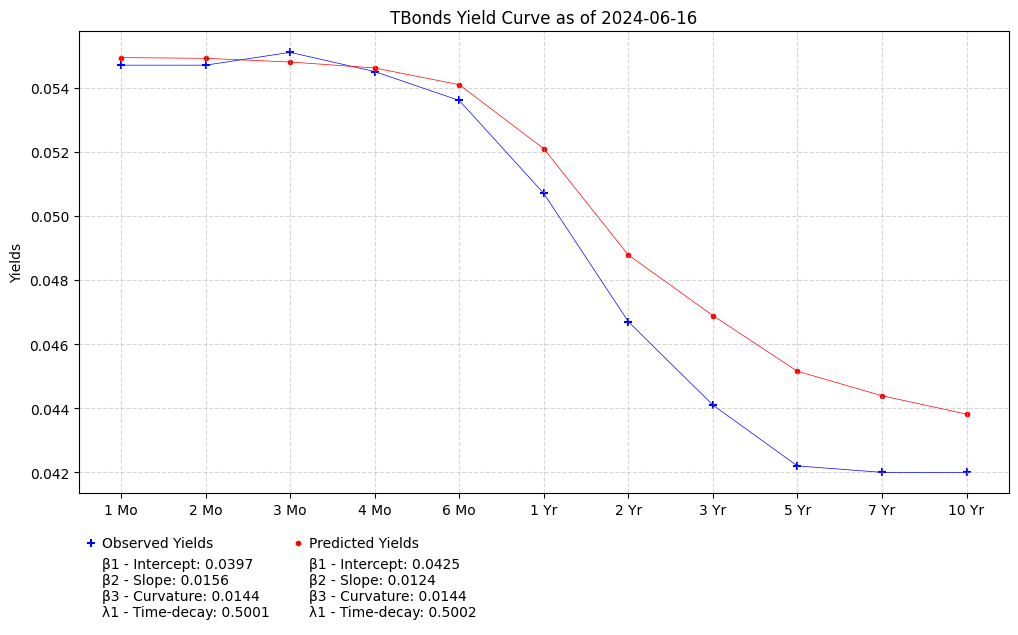

In [132]:
import matplotlib.pyplot as plt

x=-30
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot of observed bond yields
ax1.scatter(x=tbond.columns, y=np.array(tbond.iloc[x])/100, color='blue', marker='+', label="Observed Yields")
ax1.plot(tbond.columns, np.array(tbond.iloc[x])/100, color='blue', linestyle='-', linewidth=0.5)
ax1.set_ylabel('Yields', color='black')
ax1.tick_params(axis='y', colors='black')

# Plot of predicted bond yields
ax1.scatter(x=tbond_pred.columns, y=tbond_pred.iloc[x], color='red', marker='.', label="Predicted Yields")
ax1.plot(tbond_pred.columns, tbond_pred.iloc[x], color='red', linestyle='-', linewidth=0.5)

# Format Nelson-Siegel parameters as text for legend
params_test = (
    f"β1 - Intercept: {nsc_test['b1'].iloc[x]:.4f}\n"
    f"β2 - Slope: {nsc_test['b2'].iloc[x]:.4f}\n"
    f"β3 - Curvature: {nsc_test['b3'].iloc[x]:.4f}\n"
    f"λ1 - Time-decay: {nsc_test['l1'].iloc[x]:.4f}"
)
params_pred = (
    f"β1 - Intercept: {nsc_pred['b1'].iloc[x]:.4f}\n"
    f"β2 - Slope: {nsc_pred['b2'].iloc[x]:.4f}\n"
    f"β3 - Curvature: {nsc_pred['b3'].iloc[x]:.4f}\n"
    f"λ1 - Time-decay: {nsc_pred['l1'].iloc[x]:.4f}"
)

# Créer des dummy lines pour afficher les paramètres
dummy_test = plt.Line2D([], [], color="white", label=params_test)
dummpred = plt.Line2D([], [], color="white", label=params_pred)

# Récupérer les handles et labels
handles, labels = ax1.get_legend_handles_labels()

# Insérer les paramètres juste après les points correspondants
new_handles = []
new_labels = []

for h, l in zip(handles, labels):
    new_handles.append(h)
    new_labels.append(l)
    if l == "Observed Yields":
        new_handles.append(dummy_test)
        new_labels.append(params_test)
    elif l == "Predicted Yields":
        new_handles.append(dummpred)
        new_labels.append(params_pred)

# Afficher la légende avec 2 colonnes côte à côte
ax1.legend(new_handles, new_labels, bbox_to_anchor=(0, -0.3), loc='lower left', ncol=2, frameon=False, handlelength=0)

# Set plot title with the last available date in the dataset
plt.title(f"TBonds Yield Curve as of {nsc_pred.index[x].strftime('%Y-%m-%d')}")
plt.grid(alpha=0.5, linestyle='--')